In [2]:
import nest
import numpy as np
import pylab as pl
from sklearn.linear_model import LinearRegression
import sys
sys.path.append('..')
from functions import *
from enc_layer_description import plt_thresh_Vm0
from Plot_weight_matrices import plot_weight_matrices

In [3]:
# Global parameters

T = 1000  # total number of time steps
dt = 0.1  # simulation resolution
###
# Input parameters
u_range = [0., 1.]
duration = 70. # [ms]

u = np.random.uniform(low=u_range[0], high=u_range[1], size=T)
input_times = np.arange(dt, T*duration, duration)

###
# Parameters
NE = 5000 
nEnc = int(NE/5) 
J_bias = 200. # [pA] 
tuning = 250. * np.random.randn(nEnc) + 1000.

# randomize thresholds and initial states
thresholds = 5 * np.random.randn(nEnc) - 50.
Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc)))

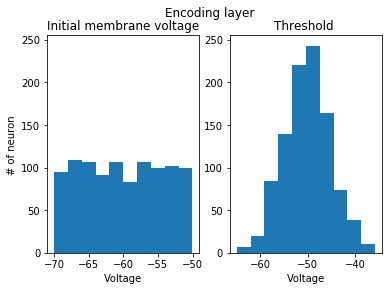

In [4]:
fig_thresh_vm0 = plt_thresh_Vm0(thresholds, Vm0)
fig_thresh_vm0.savefig('Thresh_Vm0.png')

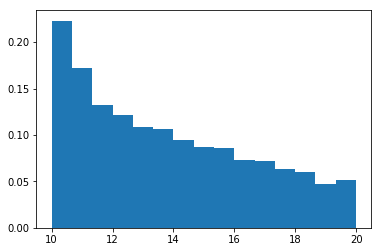

In [5]:
Thresh_circ = np.random.uniform(10.1 ,30, NE+int(0.25 * NE))
#count, bins, ignored = pl.hist(Thresh_circ, 15, density=True)
#pl.plot(bins, np.ones_like(bins), linewidth=2, color='r')
#pl.show()

vm0_min = 10
Vm0_circ = np.random.uniform(vm0_min ,20, NE+int(0.25 * NE))
#count, bins, ignored = pl.hist(Vm0_circ, 15, density=True)
#pl.plot(bins, np.ones_like(bins), linewidth=2, color='r')
#pl.show()

for n in range(NE+int(0.25 * NE) ):
    if Vm0_circ[n] > Thresh_circ[n]:
        Vm0_circ[n] = np.random.uniform(vm0_min, Thresh_circ[n])   

#count, bins, ignored = pl.hist(Vm0_circ, 15, density=True)
#pl.plot(bins, np.ones_like(bins), linewidth=2, color='r')
#pl.show()

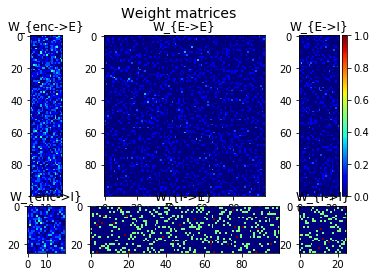

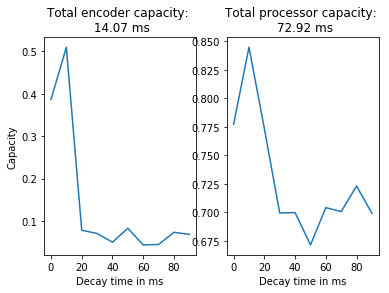

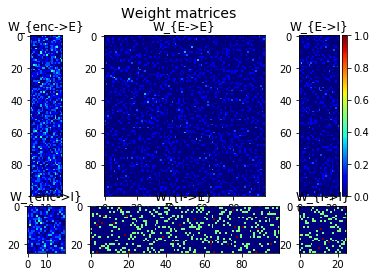

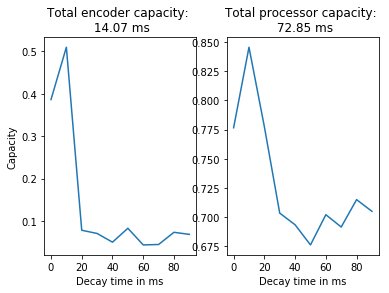

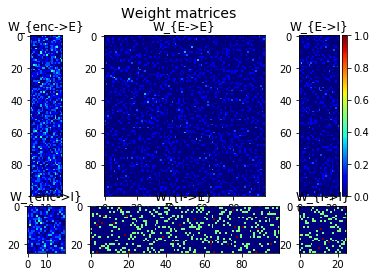

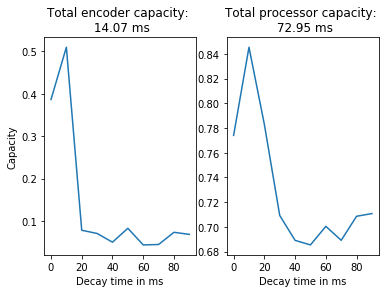

In [9]:
for sigma in [1,2,3]: #sigma = 1,2,3  standard deviation of tau_m, the param to change !! 
    #### PARAMETERS ############
    # network parameters
    gamma = 0.25               # relative number of inhibitory connections
    #NE = 5000                  # number of excitatory neurons (10.000 in [1]) #### Fixed param outside of the loop
    NI = int(gamma * NE)       # number of inhibitory neurons
    CE = int(NE/5)                   # indegree from excitatory neurons
    CI = int(gamma * CE)       # indegree from inhibitory neurons

    # synapse parameters
    w = 0.1                    # excitatory synaptic weight (mV)
    g = 5.                     # relative inhibitory to excitatory synaptic weight
    d = 1.5                    # synaptic transmission delay (ms)

    # neuron paramters
    n_ex_model = 'iaf_psc_delta'
    n_inh_model = 'iaf_psc_delta'
    V_th = 20.                 # spike threshold (mV)
    tau_m = 20.                # membrane time constant (ms)
    neuron_params = {
        'C_m': 1.0,            # membrane capacity (pF)
        'E_L': 0.,             # resting membrane potential (mV)
        'I_e': 0.,             # external input current (pA)
        'V_m': 0.,             # membrane potential (mV)
        'V_reset': 10.,        # reset membrane potential after a spike (mV)
        'V_th': V_th,          #
        't_ref': 2.0,          # refractory period (ms)
        'tau_m': tau_m,        #
    }
    ############################

    # Initialize NEST
    np.random.seed(42) ### Have to be reset if used in loop 
    nest.ResetKernel()
    nest.SetKernelStatus({
        'resolution': dt,
        'print_time': False,
        'local_num_threads': 8})

    # Encoding layer
    enc_layer = nest.Create('iaf_psc_delta', nEnc, {'I_e': J_bias})

    step_generator = nest.Create('step_current_generator', nEnc)
    amplitudes = np.zeros((nEnc, len(u)))
    for n in range(nEnc):
        amplitudes[n, :] = u * tuning[n]
        nest.SetStatus([enc_layer[n]], {'V_m': Vm0[n], 'V_th': thresholds[n]})
        nest.SetStatus([step_generator[n]], {'amplitude_times': input_times,
                                             'amplitude_values': amplitudes[n]})
        nest.Connect([step_generator[n]], [enc_layer[n]])

    enc_v = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval':dt})
    nest.Connect(enc_v, enc_layer)

    # Distribution of tau_m according to sigma
    tau_m_distrib = np.random.normal(tau_m, sigma, NE+int(0.25 * NE))
    
    # set default parameters for neurons and create neurons
    nest.SetDefaults('iaf_psc_delta', neuron_params)
    neurons_e = nest.Create(n_ex_model, NE)
    neurons_i = nest.Create(n_inh_model, NI)
    for n in range(NE):
        nest.SetStatus([neurons_e[n]], {'V_m': Vm0_circ[n], 'V_th': Thresh_circ [n], 'tau_m': tau_m_distrib[n] })

    for n in range(NI):
        nest.SetStatus([neurons_i[n]], {'V_m': Vm0_circ[NE+n], 'V_th': Thresh_circ [NE+n], 'tau_m': tau_m_distrib[NE+n]})
    

    # E synapses
    syn_exc = {'delay': d, 'weight': w}
    conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
    nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
    nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

    # I synapses
    syn_inh = {'delay': d, 'weight': - g * w}
    conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
    nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
    nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

    # device
    net_v = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': dt})
    nest.Connect(net_v, neurons_e)
    
    # Connect neurons
    nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
    nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)
    
    ## PLOT CONNEX MATRIX ## TO DO ? WITH LOW NB N ? 
    w_mat = plot_weight_matrices(neurons_e, neurons_i, enc_layer, 100, gamma)
    w_mat.savefig('Weight_matrice_HN_sigma_{0}.png'.format(str(sigma)))
    ##
    
    # Simulate
    nest.Simulate(T*duration+dt)

    # Get encoding layer and neuron_e activity
    time_vector = np.arange(0., T*duration, dt)
    signal = np.zeros_like(time_vector)
    for tt in range(len(input_times)-1):
        signal[int(input_times[tt]/dt):int(input_times[tt+1]/dt)] = u[tt]

    enc_activity = nest.GetStatus(enc_v)[0]['events']
    enc_v = [] # Reinitialize enc_v
    net_activity = nest.GetStatus(net_v)[0]['events']
    net_v = [] # Reinitialize net_v
    
    # Compute enco layer & neurons_e state
    enc_indices = np.sort(np.unique(enc_activity['senders']))
    enc_states = np.zeros((nEnc, int(T*duration/dt)))
    for idx, i in enumerate(enc_indices):
        enc_states[idx, :] = enc_activity['V_m'][np.where(enc_activity['senders']==i)[0]]

    net_indices = np.sort(np.unique(net_activity['senders']))
    e_states = np.zeros((NE, int(T*duration/dt)))
    for idx, i in enumerate(net_indices):
        e_states[idx, :] = net_activity['V_m'][np.where(net_activity['senders']==i)[0]]

    # Compute capacity
    def compute_capacity(a, y):
        """
        Compute capacity to reconstruct y based on linearly combining a
        :param a: state matrix (NxT)
        :param y: target output (1xT)
        :return y_hat: estimated signal
        :return capacity: 
        :return error:
        """
        D = np.dot(np.linalg.pinv(a.T), y.T)
        y_hat = np.dot(D, a)
        capacity = 1. - (np.mean((y - y_hat) ** 2) / np.var(y))
        error = np.mean((y - y_hat) ** 2)
        return y_hat, capacity, error


    max_lag = 100.   # [ms] in this example
    step_lag = 10.   # [ms] - if != dt (index the time axis)
    time_lags = np.arange(0., max_lag, step_lag)
    indices = [np.where(idx==time_vector)[0][0] for idx in time_lags]

    encoder_capacity = []
    circuit_capacity = []

    # Compute and save lag, enc_capacity, enc_error, circ_capacity, circ_error
    for idx, lag in zip(indices, time_lags):

        # shift the target signal
        if idx > 0:
            shifted_signal = signal[:-idx]
        else:
            shifted_signal = signal

        # shift the population states
        enc_st = enc_states[:, idx:]
        circ_st = e_states[:, idx:]

        # compute capacity
        enc_estimate, enc_capacity, enc_error = compute_capacity(enc_st, shifted_signal)
        circ_estimate, circ_capacity, circ_error = compute_capacity(circ_st, shifted_signal)
        # Save enc_capacity, enc_error 
        with open('resultsNEST_param_HN_sigma_{0}.csv'.format(str(sigma)),'a') as res_file:
            res_file.write('{0},{1},{2},{3},{4}\n'.format(
                str(lag), str(enc_capacity), str(enc_error), str(circ_capacity), str(circ_error)))

        #print("Lag = {0} ms".format(str(lag)))
        #print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
        #print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))

        encoder_capacity.append(enc_capacity)
        circuit_capacity.append(circ_capacity)

    # Get plot
    fig = pl.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(time_lags, encoder_capacity)
    ax1.set_title('Total encoder capacity: \n {0} ms'.format(str(round(np.sum(encoder_capacity)*step_lag,2))))
    ax2.plot(time_lags, circuit_capacity)
    ax2.set_title("Total processor capacity: \n {0} ms".format(str(round(np.sum(circuit_capacity)*step_lag,2))))
    ax1.set_xlabel('Decay time in ms')
    ax2.set_xlabel('Decay time in ms')
    ax1.set_ylabel('Capacity')
    pl.show()

    #print("Total capacity (encoder): {0} ms".format(str(np.sum(encoder_capacity)*step_lag)))
    #print("Total capacity (processor): {0} ms".format(str(np.sum(circuit_capacity)*step_lag)))
    fig.savefig('MemCapacity_with_HN_sigma_{0}.png'.format(str(sigma)))